In [1]:
import os
import random
import csv
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.io import read_image
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.datasets import MNIST
from torchvision.transforms import ToPILImage

import matplotlib.pyplot as plt
import matplotlib.patches as patches

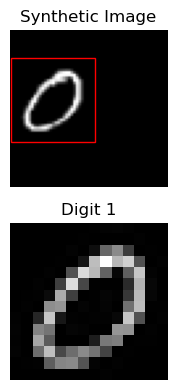

Bounding Boxes: [(0, 10, 32, 42), (0, 0, 0, 0)]


In [6]:

def create_synthetic_images(dataset, num_samples_per_class=None, image_size=(60, 60), max_overlap_ratio=1/4, max_digits=3):
    synthetic_images = []

    if num_samples_per_class is None:
        num_samples_per_class = {i: 1000 for i in range(max_digits + 1)}

    for num_digits, num_samples in num_samples_per_class.items():
        for _ in range(num_samples):
            selected_indices = random.sample(range(len(dataset)), num_digits)
            images = [ToPILImage()(dataset[idx][0]) for idx in selected_indices]

            synthetic_img = Image.new('L', image_size, color=0)

            x_offset = 0
            bounding_boxes = []
            confidences = [0] * max_digits  

            digit_counter = 0  
            for img in images:
                resize_factor = random.uniform(0.8, 1.2)
                img = img.resize((int(img.width * resize_factor), int(img.height * resize_factor)))

                if len(bounding_boxes) > 0:
                    max_overlap = int(img.width * max_overlap_ratio)
                    overlap = random.randint(0, max_overlap)
                    x_offset -= overlap

                max_y_offset = max(0, image_size[1] - img.height)
                y_offset = random.randint(0, max_y_offset)

                if x_offset + img.width <= image_size[0]:  
                    synthetic_img.paste(img, (x_offset, y_offset))
                    bounding_boxes.append((x_offset, y_offset, x_offset + img.width, y_offset + img.height))
                    confidences[digit_counter] = 1  
                    digit_counter += 1 
                    x_offset += img.width
                else:
                    break

            while len(bounding_boxes) < max_digits:
                bounding_boxes.append((0, 0, 0, 0))

            synthetic_images.append((synthetic_img, bounding_boxes, confidences))

    return synthetic_images


def visualize_synthetic_image_with_rois(image, bounding_boxes, fixed_size=(14, 14)):
    num_digits = len([bbox for bbox in bounding_boxes if bbox[2] - bbox[0] > 0])
    fig, axes = plt.subplots(num_digits + 1, 1, figsize=(4, 2 * (num_digits + 1)))

    if num_digits == 0:
        axes = [axes]

    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Synthetic Image')
    for bbox in bounding_boxes:
        if bbox[2] - bbox[0] > 0:
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=1, edgecolor='r', facecolor='none')
            axes[0].add_patch(rect)
    axes[0].axis('off')

    digit_index = 1
    for bbox in bounding_boxes:
        if bbox[2] - bbox[0] > 0 and digit_index <= num_digits:
            digit = image.crop(bbox).resize(fixed_size, Image.LANCZOS)
            if num_digits > 0:
                ax = axes[digit_index]
            else:
                ax = axes
            ax.imshow(digit, cmap='gray')
            ax.set_title(f'Digit {digit_index}')
            ax.axis('off')
            digit_index += 1

    plt.tight_layout()
    plt.show()


mnist_transform = transforms.Compose([transforms.ToTensor()])

mnist_train = MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_test = MNIST(root='./data', train=False, download=True, transform=mnist_transform)

num_samples_per_class = {0: 0, 1: 5000, 2: 7500}
# num_samples_per_class = {0: 2000, 1: 2000, 2: 2000, 3: 2000}
synthetic_dataset = create_synthetic_images(mnist_train, num_samples_per_class=num_samples_per_class, max_digits=2)

first_image, first_bounding_boxes, first_labels = synthetic_dataset[random.randint(0, len(synthetic_dataset) - 1)]
visualize_synthetic_image_with_rois(first_image, first_bounding_boxes)

print("Bounding Boxes:", first_bounding_boxes)

In [7]:
def save_synthetic_dataset_csv(dataset, save_dir='synthetic_dataset_csv'):
    os.makedirs(save_dir, exist_ok=True)
    csv_filename = 'bounding_boxes.csv'
    csv_path = os.path.join(save_dir, csv_filename)

    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['image_filename', 'x_min', 'y_min', 'x_max', 'y_max', 'confidence'])

        for i, (image, bounding_boxes, confidences) in enumerate(dataset):
            image_filename = f'image_{i}.png'
            image_path = os.path.join(save_dir, image_filename)

            image.save(image_path)

            for bbox, confidence in zip(bounding_boxes, confidences):
                writer.writerow([image_filename] + list(bbox) + [confidence])

save_synthetic_dataset_csv(synthetic_dataset)

In [135]:
class SyntheticMNISTDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.bbox_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.bbox_frame['image_filename'].unique())

    def __getitem__(self, idx):
        img_filename = self.bbox_frame['image_filename'].unique()[idx]
        img_path = os.path.join(self.img_dir, img_filename)
        image = read_image(img_path)

        img_bboxes = self.bbox_frame[self.bbox_frame['image_filename'] == img_filename]

        bbox_and_confidence = img_bboxes[['x_min', 'y_min', 'x_max', 'y_max', 'confidence']].values
        bbox_and_confidence = bbox_and_confidence.astype('float').reshape(-1, 5)

        bbox = bbox_and_confidence[:, :4]
        confidence = bbox_and_confidence[:, 4]

        sample = {'image': image, 'bbox': bbox, 'confidence': confidence}

        if self.transform:
            sample = self.transform(sample)

        return sample

dataset = SyntheticMNISTDataset(csv_file='synthetic_dataset_csv/bounding_boxes.csv',
                                img_dir='synthetic_dataset_csv',
                                transform=None)


# dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)  


Using device: mps


/Users/ronald/miniconda3/envs/ml/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ronald/miniconda3/envs/ml/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 0.0997, -0.4031, -0.3501,  0.1138,  0.0321,  0.0766, -0.2557,  0.1770],
       device='mps:0', grad_fn=<SelectBackward0>)


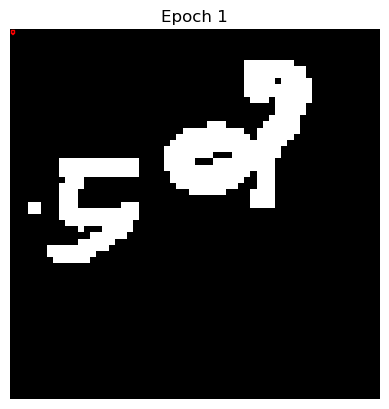

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 0.0607, 15.3116, 16.8194, 34.7885,  4.3423,  4.9547,  1.4507,  2.1086],
       device='mps:0', grad_fn=<SelectBackward0>)


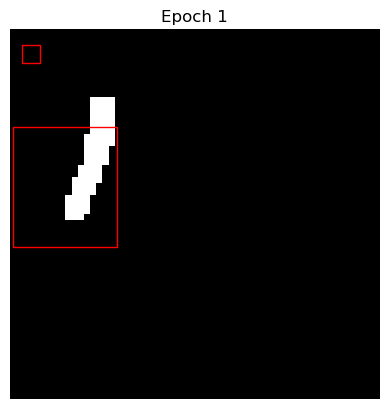

Epoch [1/10], Loss: 24.39560890197754


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([-0.6037, 22.5067, 33.2299, 55.4779, 24.8172, 15.5989, 52.0900, 42.6279],
       device='mps:0', grad_fn=<SelectBackward0>)


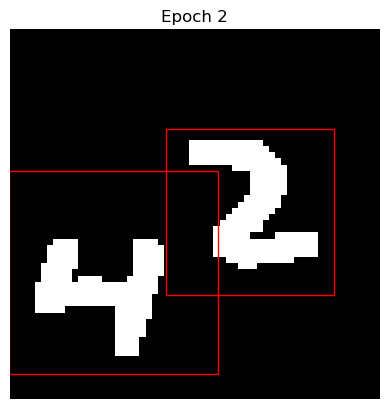

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 0.1623, 14.6901, 22.9077, 37.6939, -0.2952,  0.1874, -0.6973,  0.3200],
       device='mps:0', grad_fn=<SelectBackward0>)


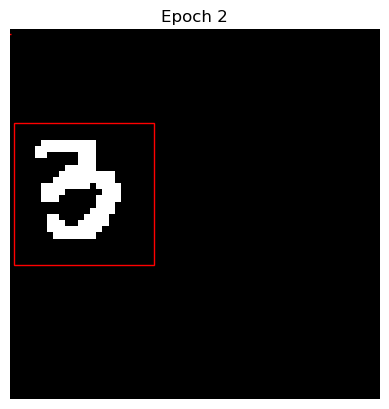

Epoch [2/10], Loss: 23.58332061767578


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 9.1651e-03,  2.0898e+01,  2.8962e+01,  4.9852e+01,  4.5013e-01,
        -6.6519e-01,  9.4370e-01, -3.2318e-01], device='mps:0',
       grad_fn=<SelectBackward0>)


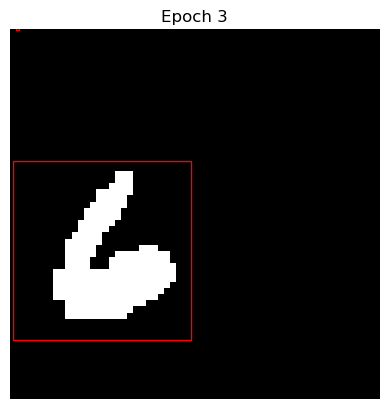

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([4.7171e-02, 2.7953e+01, 2.4039e+01, 5.1108e+01, 1.9713e+01, 1.7202e+01,
        4.4305e+01, 4.0948e+01], device='mps:0', grad_fn=<SelectBackward0>)


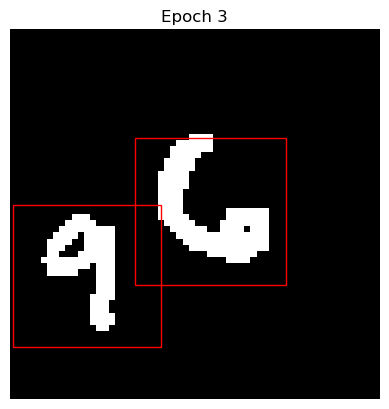

Epoch [3/10], Loss: 9.234492301940918


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 0.0780, 32.4730, 27.5969, 59.9036, 24.5855, 13.1263, 53.0553, 41.2699],
       device='mps:0', grad_fn=<SelectBackward0>)


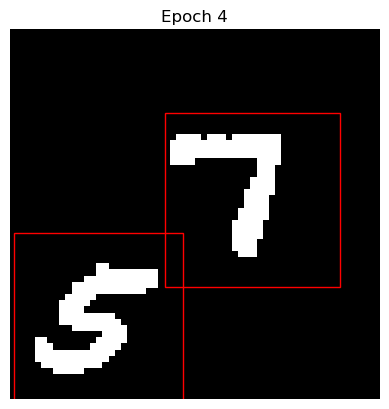

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([-2.4828e-02,  2.8563e+01,  2.6357e+01,  5.5330e+01, -5.1651e-01,
        -2.2719e-01, -8.1114e-01, -7.0562e-01], device='mps:0',
       grad_fn=<SelectBackward0>)


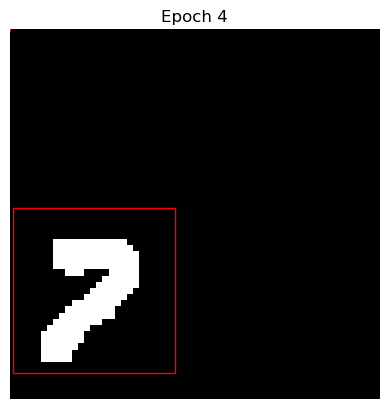

Epoch [4/10], Loss: 5.992341041564941


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([-0.0833, 22.8817, 26.4329, 49.2838, 22.5826, 24.3884, 49.4740, 51.5662],
       device='mps:0', grad_fn=<SelectBackward0>)


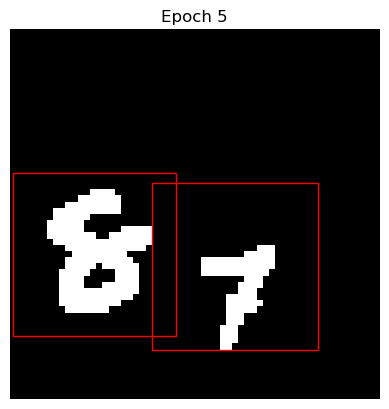

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([-0.0810,  4.3203, 24.1089, 29.1178, 22.4865,  0.2251, 46.1636, 23.7256],
       device='mps:0', grad_fn=<SelectBackward0>)


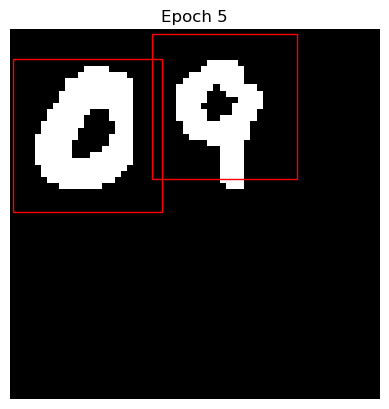

Epoch [5/10], Loss: 7.220117568969727


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([-0.0736, 18.3367, 25.2193, 44.0292, 22.3595,  4.2773, 48.5024, 30.3905],
       device='mps:0', grad_fn=<SelectBackward0>)


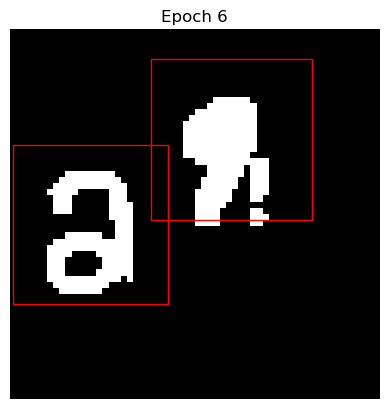

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 0.0910, 19.5572, 30.7561, 50.1299, 26.5507,  7.2059, 55.1304, 36.0138],
       device='mps:0', grad_fn=<SelectBackward0>)


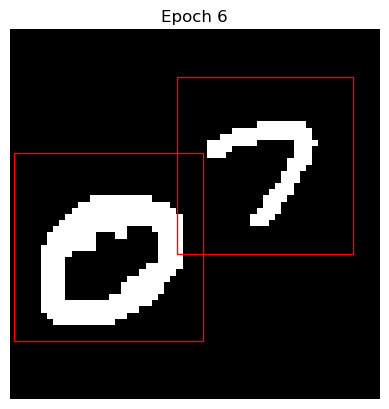

Epoch [6/10], Loss: 4.198516368865967


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 0.2088, 28.5213, 28.9678, 57.7629, 26.4133,  8.0993, 55.2449, 37.2782],
       device='mps:0', grad_fn=<SelectBackward0>)


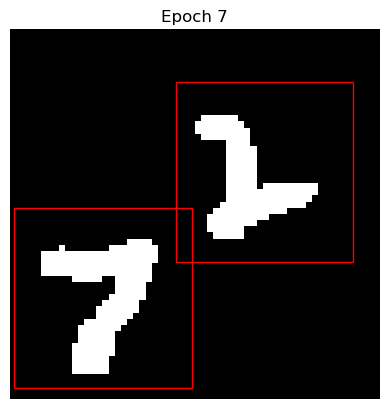

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 0.0579, 14.0616, 29.1918, 43.9052, 25.3931, -0.8995, 52.2855, 26.3818],
       device='mps:0', grad_fn=<SelectBackward0>)


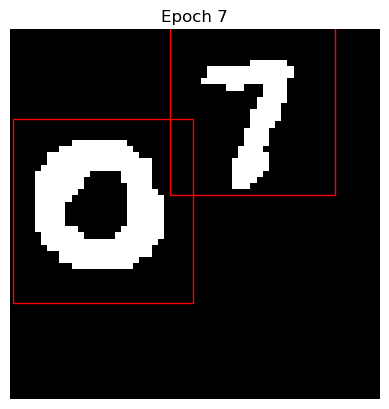

Epoch [7/10], Loss: 5.955098628997803


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([-0.1352, 20.4915, 22.7841, 43.9209, 19.9440,  9.9353, 46.4199, 36.3468],
       device='mps:0', grad_fn=<SelectBackward0>)


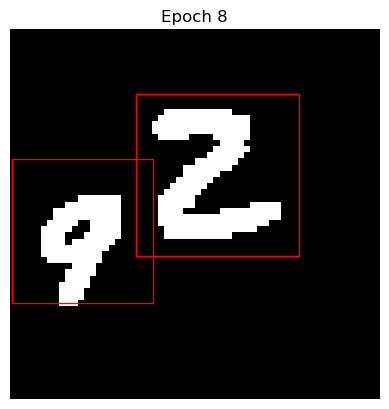

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 0.1258, 25.2261, 24.6219, 49.3040, 19.3141, 33.1182, 43.0830, 56.4717],
       device='mps:0', grad_fn=<SelectBackward0>)


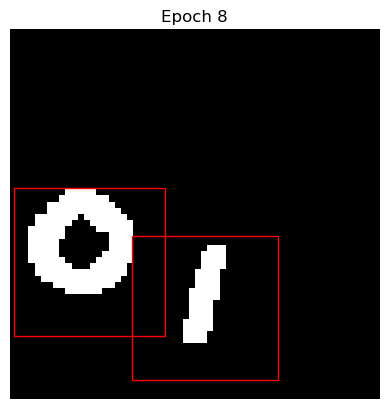

Epoch [8/10], Loss: 16.115896224975586


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([-0.1232, 11.3566, 27.9122, 39.1730, 25.7248, 27.7986, 55.4399, 57.5312],
       device='mps:0', grad_fn=<SelectBackward0>)


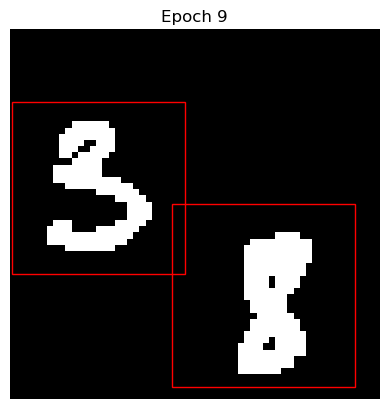

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 1.0518e-01,  2.7861e+00,  2.8197e+01,  3.0444e+01, -5.8199e-02,
         5.7347e-01, -5.4087e-01, -1.7221e-03], device='mps:0',
       grad_fn=<SelectBackward0>)


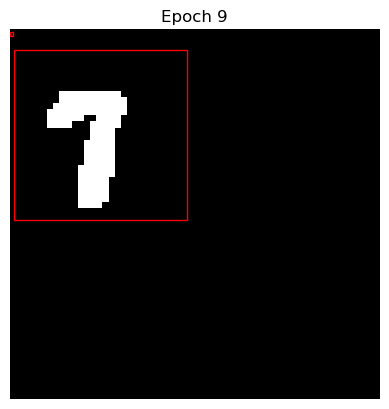

Epoch [9/10], Loss: 13.178473472595215


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.2438e-02, 1.2718e+01, 3.0483e+01, 4.2404e+01, 2.6299e+01, 1.8928e+01,
        5.1911e+01, 4.4358e+01], device='mps:0', grad_fn=<SelectBackward0>)


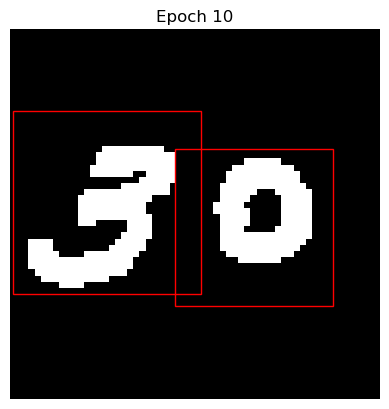

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 0.0543, 12.0919, 31.2136, 43.2425,  0.4652, -0.2757,  0.2923, -0.2782],
       device='mps:0', grad_fn=<SelectBackward0>)


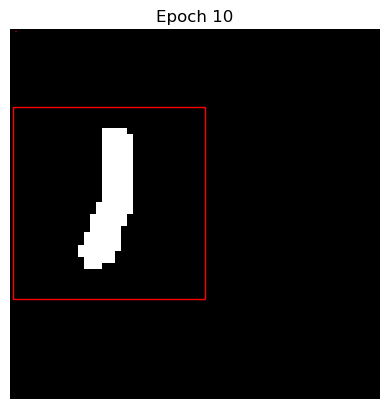

Epoch [10/10], Loss: 2.3054165840148926


In [136]:
class DigitSegmentationModel(nn.Module):
    def __init__(self):
        super(DigitSegmentationModel, self).__init__()
        self.base_model = resnet18(pretrained=True)
        self.base_model.fc = nn.Identity()

        self.fc_layers = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10) #(4*num_digits + num_digits) 
            # nn.Linear(64, 15) #(4*num_digits + num_digits) 
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.fc_layers(x)
        bbox_presence_scores = x[:, :8]
        digit_count_scores = x[:, 8:]
        return bbox_presence_scores, digit_count_scores



def train_model_with_visualization(model, dataloader, epochs=10):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    bbox_loss_fn = nn.MSELoss()
    count_loss_fn = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        for i, batch in enumerate(dataloader):
            images = batch['image'].float()

            if images.size(1) == 1:
                images = images.repeat(1, 3, 1, 1)

            bbox_targets = batch['bbox'].float()
            confidence_targets = batch['confidence'].float()
            images, bbox_targets, confidence_targets = images.to(device), bbox_targets.to(device), confidence_targets.to(device)
            
            bbox_predictions, confidence_predictions = model(images)

            bbox_loss = bbox_loss_fn(bbox_predictions, bbox_targets.view(-1, 8))

            confidence_loss = count_loss_fn(confidence_predictions, confidence_targets)

            total_loss = bbox_loss + confidence_loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            if i % 50 == 0:
                print(bbox_predictions[0])
                visualize_example(images[0], bbox_predictions[0], epoch)

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss.item()}')



def visualize_example(image, predictions, epoch):
    predictions_array = predictions.squeeze().detach().cpu().numpy().reshape(-1, 4)

    image = image.cpu().permute(1, 2, 0).numpy()

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for bbox in predictions_array:
        x_min, y_min, x_max, y_max = bbox
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.title(f'Epoch {epoch+1}')
    plt.show()


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

model = DigitSegmentationModel()
model = model.to(device)
train_model_with_visualization(model, dataloader, epochs=10)
torch.save(model.state_dict(), 'digit_segmentation_model.pth')


/Users/ronald/miniconda3/envs/ml/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ronald/miniconda3/envs/ml/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 60, 60])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


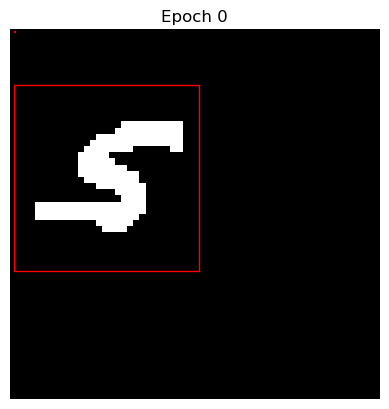

tensor([ 0.0916,  8.5799, 30.2543, 38.7840,  0.3641, -0.0837,  0.1835, -0.1615])
Validation Batch [1/20], Loss: 0.9492453336715698
torch.Size([1, 60, 60])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


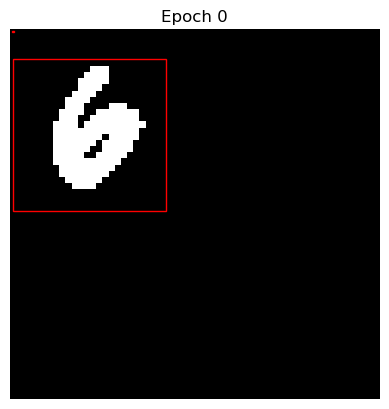

tensor([ 1.8683e-02,  4.2889e+00,  2.4752e+01,  2.8999e+01,  8.7897e-02,
        -1.5705e-01, -9.6551e-02, -3.1998e-01])
Validation Batch [2/20], Loss: 1.1437712907791138
torch.Size([1, 60, 60])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


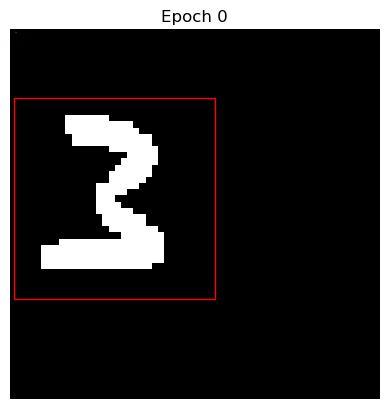

tensor([ 9.1002e-02,  1.0582e+01,  3.2735e+01,  4.3244e+01,  4.8476e-01,
        -4.1630e-02,  3.5236e-01, -9.0385e-02])
Validation Batch [3/20], Loss: 0.9332602024078369
torch.Size([1, 60, 60])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


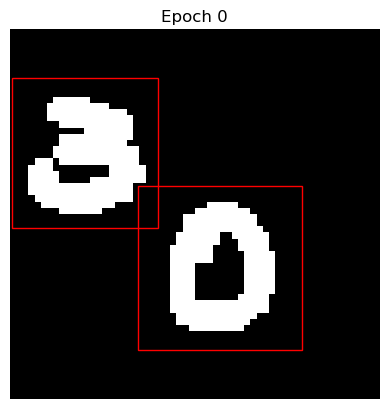

tensor([-0.1379,  7.4342, 23.5590, 31.6863, 20.2853, 24.8819, 46.8569, 51.5903])
Validation Batch [4/20], Loss: 1.0053927898406982
torch.Size([1, 60, 60])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


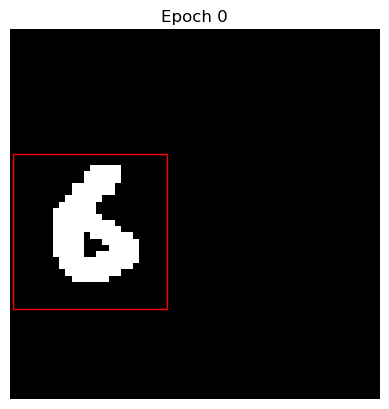

tensor([ 5.6157e-03,  1.9656e+01,  2.5047e+01,  4.4914e+01, -3.8591e-02,
        -2.8577e-01, -6.1156e-02, -2.9641e-01])
Validation Batch [5/20], Loss: 1.0091478824615479
torch.Size([1, 60, 60])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


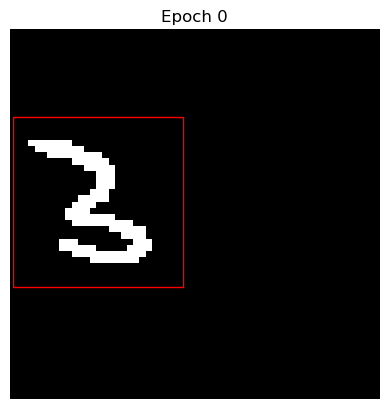

tensor([ 0.0546, 13.7896, 27.5046, 41.3906,  0.1528, -0.1852,  0.0694, -0.1830])
Validation Batch [6/20], Loss: 0.7852845191955566
torch.Size([1, 60, 60])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


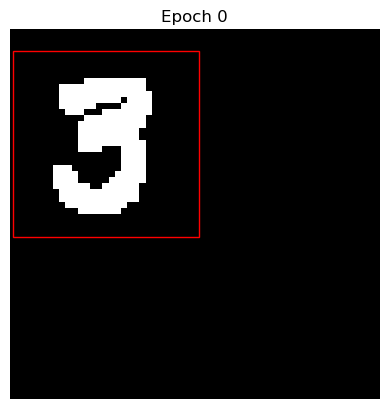

tensor([-1.6421e-02,  3.0451e+00,  3.0107e+01,  3.3193e+01,  1.6355e-01,
        -1.9870e-01,  1.6957e-01, -2.4443e-01])
Validation Batch [7/20], Loss: 0.9872093200683594
torch.Size([1, 60, 60])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


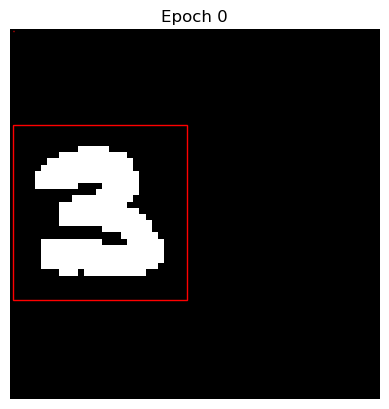

tensor([ 4.7463e-02,  1.5006e+01,  2.8217e+01,  4.3359e+01,  1.3445e-01,
        -2.2100e-01,  2.1598e-02, -2.5533e-01])
Validation Batch [8/20], Loss: 1.0299574136734009
torch.Size([1, 60, 60])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


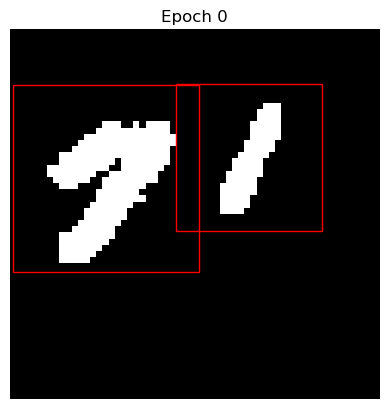

tensor([-1.8378e-02,  8.4889e+00,  3.0189e+01,  3.8907e+01,  2.6444e+01,
         8.3943e+00,  5.0191e+01,  3.2214e+01])
Validation Batch [9/20], Loss: 0.8864356875419617
torch.Size([1, 60, 60])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


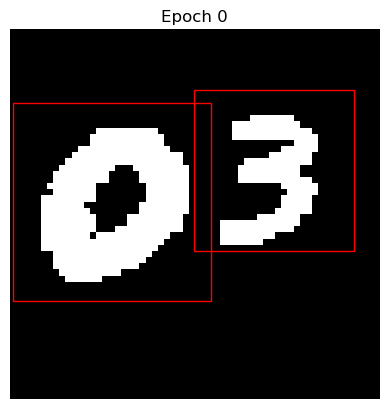

tensor([4.9224e-02, 1.1397e+01, 3.2086e+01, 4.3651e+01, 2.9291e+01, 9.3127e+00,
        5.5283e+01, 3.5402e+01])
Validation Batch [10/20], Loss: 1.0876785516738892
torch.Size([1, 60, 60])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


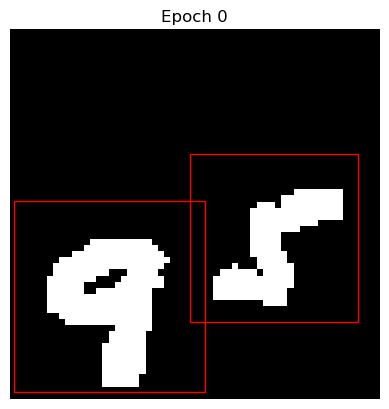

tensor([ 0.0828, 27.4138, 31.1186, 58.4442, 28.7679, 19.7628, 55.9866, 47.0588])
Validation Batch [11/20], Loss: 0.7948111891746521
torch.Size([1, 60, 60])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


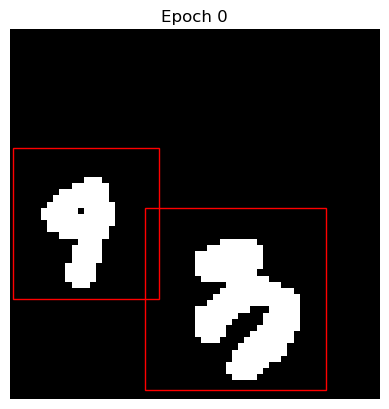

tensor([-5.6391e-02,  1.8756e+01,  2.3683e+01,  4.3295e+01,  2.1363e+01,
         2.8416e+01,  5.0837e+01,  5.8054e+01])
Validation Batch [12/20], Loss: 0.9301655292510986
torch.Size([1, 60, 60])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


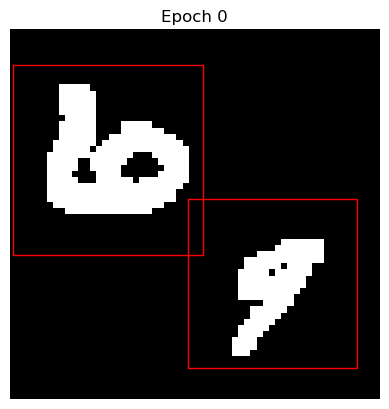

tensor([2.8685e-02, 5.2619e+00, 3.0838e+01, 3.6159e+01, 2.8439e+01, 2.6991e+01,
        5.5810e+01, 5.4507e+01])
Validation Batch [13/20], Loss: 0.8863016366958618
torch.Size([1, 60, 60])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


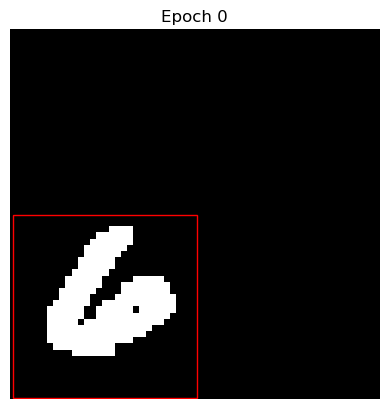

tensor([-7.8433e-03,  2.9567e+01,  2.9782e+01,  5.9361e+01,  4.1443e-01,
        -7.4249e-02,  4.5457e-01, -2.3506e-02])
Validation Batch [14/20], Loss: 0.7858755588531494
torch.Size([1, 60, 60])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


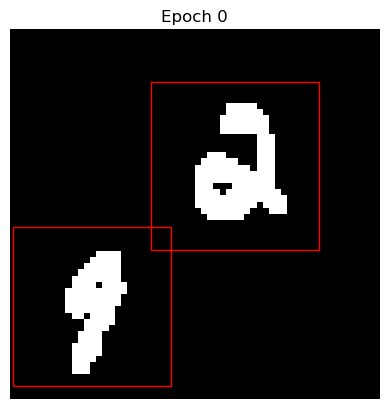

tensor([-0.0579, 31.5650, 25.6052, 57.3442, 22.3578,  8.0658, 49.7082, 35.3600])
Validation Batch [15/20], Loss: 1.092956781387329
torch.Size([1, 60, 60])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


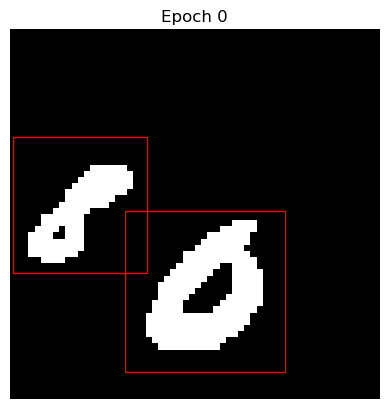

tensor([-4.0449e-02,  1.6900e+01,  2.1676e+01,  3.9099e+01,  1.8179e+01,
         2.9041e+01,  4.4199e+01,  5.5119e+01])
Validation Batch [16/20], Loss: 0.8222389221191406
torch.Size([1, 60, 60])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


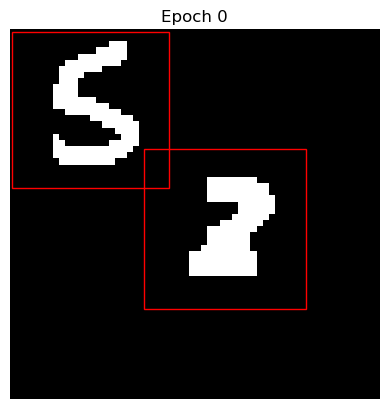

tensor([-2.5082e-01, -1.1379e-02,  2.5334e+01,  2.5215e+01,  2.1307e+01,
         1.8855e+01,  4.7561e+01,  4.4917e+01])
Validation Batch [17/20], Loss: 0.8146385550498962
torch.Size([1, 60, 60])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


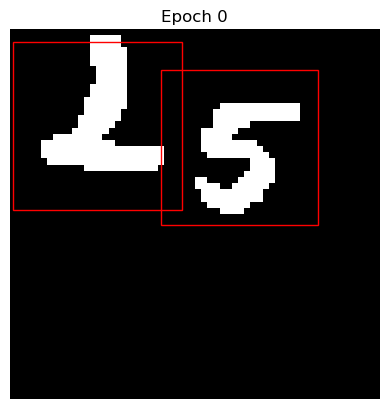

tensor([4.5000e-02, 1.5894e+00, 2.7393e+01, 2.8758e+01, 2.4079e+01, 6.1466e+00,
        4.9422e+01, 3.1176e+01])
Validation Batch [18/20], Loss: 0.9337863922119141
torch.Size([1, 60, 60])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


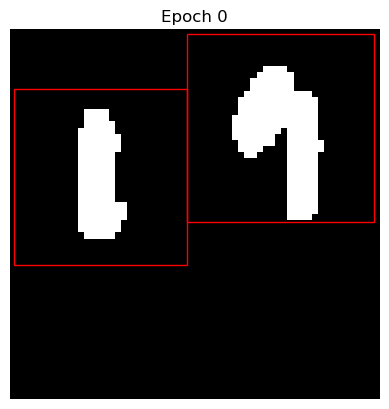

tensor([ 0.1228,  9.1845, 28.2903, 37.8210, 28.2578,  0.2700, 58.6226, 30.6914])
Validation Batch [19/20], Loss: 0.9709446430206299
torch.Size([1, 60, 60])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


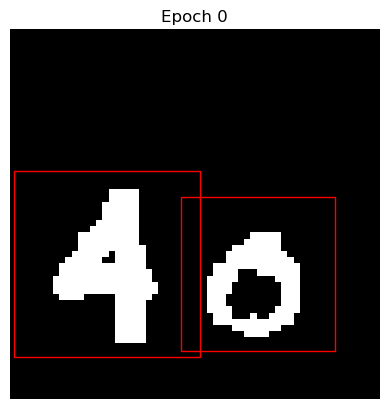

tensor([ 0.0951, 22.5048, 30.3158, 52.6041, 27.2990, 26.7764, 52.2525, 51.7813])
Validation Batch [20/20], Loss: 0.9733096957206726


In [137]:

def test_model_with_visualization(model, dataloader):
    model.eval()
    bbox_loss_fn = nn.MSELoss()
    count_loss_fn = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            images = batch['image'].float()
            print(images[0].shape)
            if images.size(1) == 1:
                images = images.repeat(1, 3, 1, 1)
            # print(images)

            bbox_targets = batch['bbox'].float()
            confidence_targets = batch['confidence'].float()

            bbox_predictions, confidence_predictions = model(images)

            bbox_loss = bbox_loss_fn(bbox_predictions, bbox_targets.view(-1, 8))
            confidence_loss = count_loss_fn(confidence_predictions, confidence_targets)

            total_loss = bbox_loss + confidence_loss

            visualize_example(images[0], bbox_predictions[0], epoch=-1)            
            print(bbox_predictions[0])
            # for i in range(1):  # Loop through the first 6 examples
                # visualize_example(images[i], bbox_predictions[i], epoch=-1)            
                # print(bbox_predictions[i])
            print(f'Validation Batch [{i+1}/{len(dataloader)}], Loss: {total_loss.item()}')


model = DigitSegmentationModel()

model.load_state_dict(torch.load('digit_segmentation_model.pth'))
test_model_with_visualization(model, test_loader)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 1:
Bounding Box Predictions: tensor([[6.3560e-03, 1.6520e+01, 2.9515e+01, 4.6134e+01, 2.6077e+01, 1.5176e+01,
         5.2951e+01, 4.2114e+01]])
Confidence Predictions: tensor([[26.4645, 13.9317]])


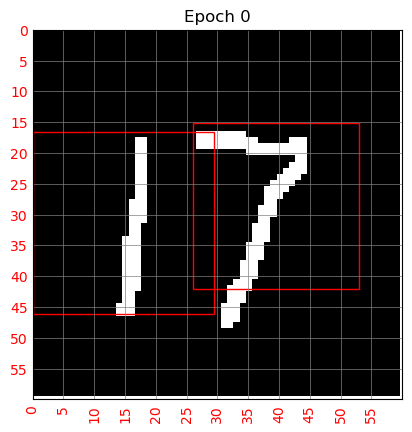

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 2:
Bounding Box Predictions: tensor([[ 0.1534, 11.7462, 25.4161, 37.4768, 24.8460,  5.3118, 55.0353, 35.5164]])
Confidence Predictions: tensor([[22.1807, 16.3562]])


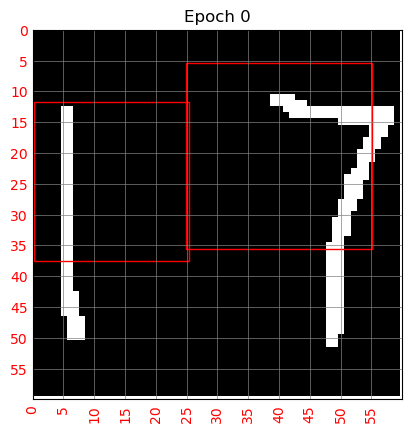

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 3:
Bounding Box Predictions: tensor([[-1.8491e-02,  1.1197e+01,  3.2655e+01,  4.3935e+01,  2.8648e+01,
          1.3746e+01,  5.2823e+01,  3.8035e+01]])
Confidence Predictions: tensor([[26.7733, 14.6614]])


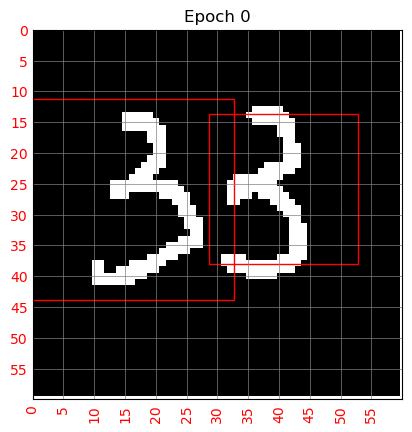

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 4:
Bounding Box Predictions: tensor([[ 0.2298,  5.1323, 28.2542, 33.4855, 28.0221,  4.9826, 57.8070, 34.6269]])
Confidence Predictions: tensor([[22.3063, 18.8870]])


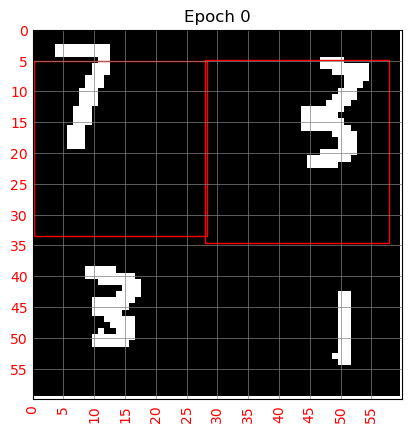

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 5:
Bounding Box Predictions: tensor([[ 0.2820, 28.2960, 20.9047, 49.8295, 17.6336, 29.9131, 43.5835, 55.6257]])
Confidence Predictions: tensor([[25.4145,  8.6066]])


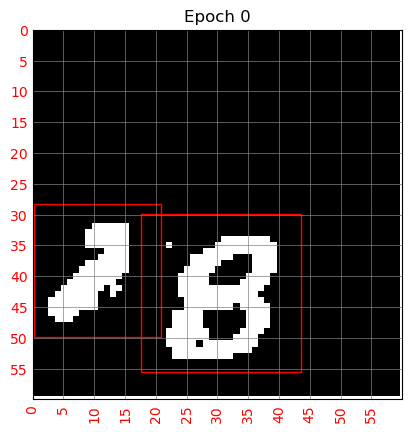

Image 6:
Bounding Box Predictions: tensor([[ 0.0531, 15.8494, 32.7990, 48.6607,  0.3827, -0.1123,  0.3440, -0.1049]])
Confidence Predictions: tensor([[ 16.8181, -11.5564]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


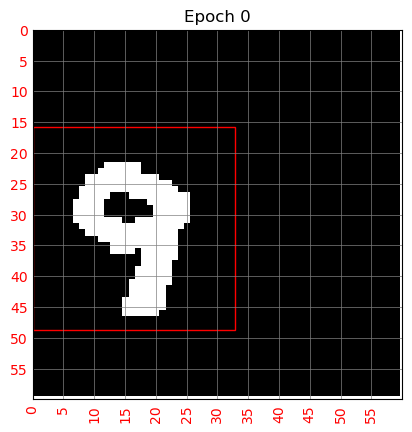

Image 7:
Bounding Box Predictions: tensor([[-7.3397e-03,  4.5237e+00,  3.0870e+01,  3.5372e+01,  2.3616e-01,
         -1.4244e-01,  1.0417e-01, -3.0685e-01]])
Confidence Predictions: tensor([[13.6764, -8.7625]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


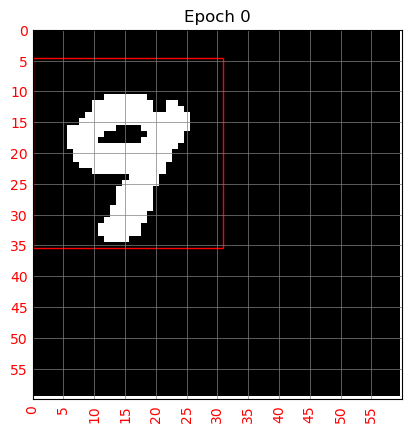

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 8:
Bounding Box Predictions: tensor([[ 3.2384e-02,  1.9650e+01,  3.2317e+01,  5.1992e+01,  3.6182e-01,
         -1.2380e-01,  3.7737e-01, -8.2060e-02]])
Confidence Predictions: tensor([[ 17.4648, -12.3814]])


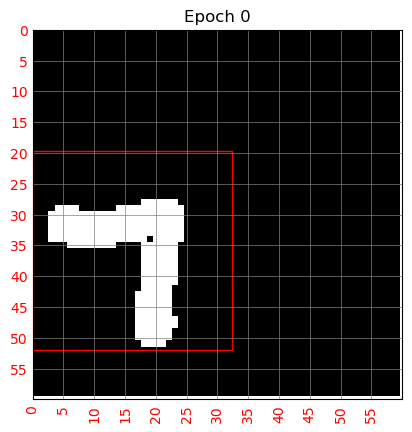

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 9:
Bounding Box Predictions: tensor([[ 2.7582e-02,  1.8285e+01,  2.9676e+01,  4.8123e+01,  1.2419e-01,
         -2.5615e-01,  6.0188e-02, -2.7756e-01]])
Confidence Predictions: tensor([[ 16.0601, -11.6144]])


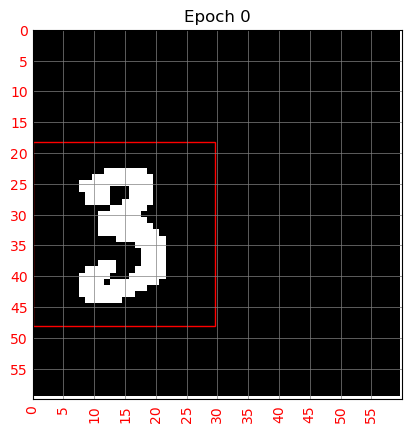

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 10:
Bounding Box Predictions: tensor([[-1.9135e-02,  4.6610e+00,  2.9751e+01,  3.4389e+01,  2.6613e+01,
          4.6520e-01,  5.0115e+01,  2.3875e+01]])
Confidence Predictions: tensor([[21.7063, 15.0316]])


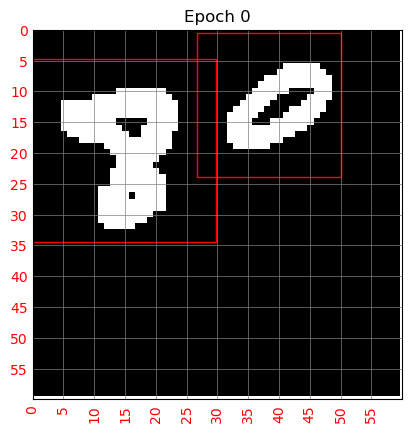

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 11:
Bounding Box Predictions: tensor([[ 9.1489e-03,  3.2522e+00,  2.4388e+01,  2.7607e+01,  6.5619e-02,
         -1.7065e-01,  1.8638e-02, -2.2869e-01]])
Confidence Predictions: tensor([[10.7352, -6.9449]])


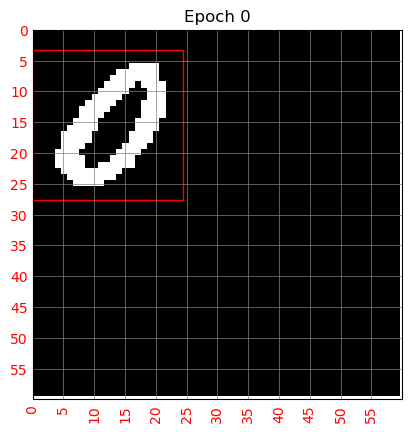

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 12:
Bounding Box Predictions: tensor([[ 5.2810e-02,  1.3137e+01,  2.6047e+01,  3.9296e+01,  9.9221e-02,
         -2.0421e-01, -1.7380e-04, -2.0975e-01]])
Confidence Predictions: tensor([[13.4734, -9.4819]])


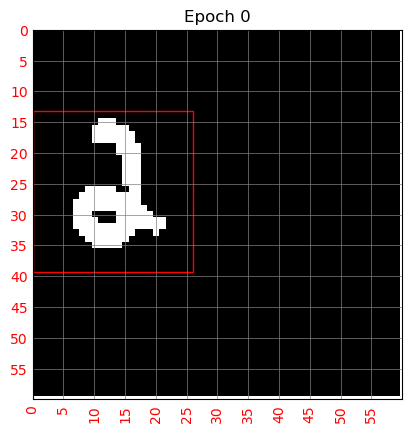

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 13:
Bounding Box Predictions: tensor([[-0.0735, 31.3899, 22.4713, 53.8051,  0.3225,  0.0845,  0.3858,  0.0627]])
Confidence Predictions: tensor([[ 16.4693, -12.7431]])


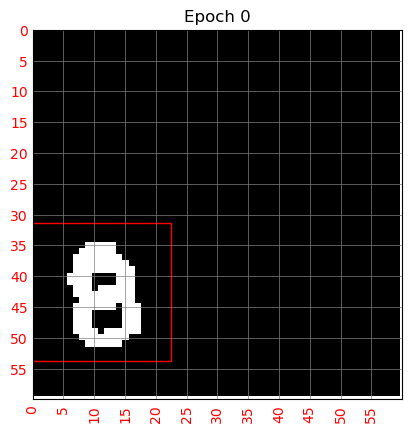

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 14:
Bounding Box Predictions: tensor([[-0.1054, 33.3571, 23.2973, 56.5536,  0.4529,  0.1308,  0.5413,  0.0966]])
Confidence Predictions: tensor([[ 17.2775, -13.3143]])


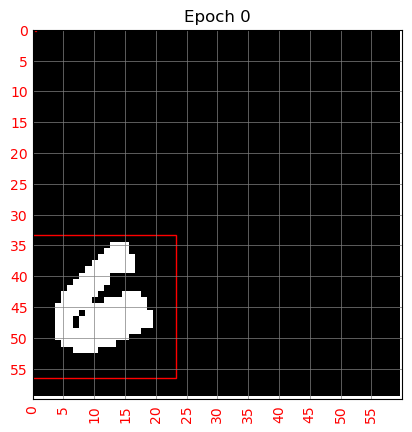

In [139]:
class IndividualImagesDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = read_image(image_path)
        
        if image.shape[0] == 4:  
            image = image[:3, :, :]

        resize_transform = transforms.Resize((60, 60))
        
        resize_image = resize_transform(image)

        return resize_image


transform = transforms.Compose([
    transforms.Resize((60, 60)),  
    transforms.ToTensor(),  
])



folder_path = 'synthetic_dataset_csv/'
original_image_paths = ['17.png', '1_7.png', '33.png', '7331.png']
# original_image_paths = []

new_random_numbers = random.sample(range(0, 10001), 10)  
new_image_paths_extended = [f"{folder_path}image_{num}.png" for num in new_random_numbers]
# new_image_paths_extended = []
image_paths = original_image_paths + new_image_paths_extended
# image_paths = ['synthetic_dataset_csv/image_1980.png', 'synthetic_dataset_csv/image_643.png', '17.png', '1_7.png', '33.png', '7331.png']


dataset = IndividualImagesDataset(image_paths, transform=transform)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)  

def visualize(image, predictions, epoch):
    predictions_array = predictions.squeeze().detach().numpy().reshape(2, 4)

    fig, ax = plt.subplots(1)

    image_np = image.permute(1, 2, 0).numpy()

    ax.imshow(image_np, cmap='gray')

    for bbox in predictions_array:
        x_min, y_min, x_max, y_max = bbox
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    ax.set_xticks(np.arange(0, image_np.shape[1], step=5))
    ax.set_yticks(np.arange(0, image_np.shape[0], step=5))

    ax.xaxis.set_tick_params(size=0)
    ax.yaxis.set_tick_params(size=0)

    plt.xticks(rotation=90)

    ax.set_xlim([0, image_np.shape[1]])
    ax.set_ylim([image_np.shape[0], 0])

    ax.grid(True, which='both', color='gray', linestyle='-', linewidth=0.5)
    ax.tick_params(axis='x', colors='red')
    ax.tick_params(axis='y', colors='red')

    plt.axis('on')  
    plt.title(f'Epoch {epoch+1}')
    plt.show()

def test_model_with_dataloader(model, dataloader):
    model.eval()
    with torch.no_grad():
        for i, images in enumerate(dataloader):
            if images.size(1) == 1: 
                images = images.repeat(1, 3, 1, 1)

            images = images.float()
            bbox_predictions, confidence_predictions = model(images)
            print(f"Image {i+1}:")
            print("Bounding Box Predictions:", bbox_predictions)
            print("Confidence Predictions:", confidence_predictions)
            visualize(images[0], bbox_predictions[0], epoch=-1)

model = DigitSegmentationModel()
model.load_state_dict(torch.load('digit_segmentation_model.pth'))

test_model_with_dataloader(model, dataloader)
